<a href="https://colab.research.google.com/github/aayushi-goenka/Medico/blob/main/attention_based_model_changedcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.models import Model, load_model  
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, Activation, add, Concatenate, RepeatVector, Bidirectional, Flatten, Multiply, Lambda
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers
from keras import backend as K
from keras.utils.vis_utils import plot_model
from IPython.display import Image, display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the CSV dataset
dataset = pd.read_csv('/content/drive/MyDrive/data1.csv')
dataset.head(5)

,Unnamed: 0,image_id,mesh,Image_path,report
0,0,CXR3695_IM-1845-1001.png,Pulmonary Congestion/mild,/content/drive/MyDrive/dataset-iu/dataset-iu-i...,startseq mild central vascular prominence cong...
1,1,CXR3695_IM-1845-2001.png,Pulmonary Congestion/mild,/content/drive/MyDrive/dataset-iu/dataset-iu-i...,startseq mild central vascular prominence cong...
2,2,CXR3703_IM-1850-1001.png,normal,/content/drive/MyDrive/dataset-iu/dataset-iu-i...,startseq no evidence acute cardiopulmonary pro...
3,3,CXR3703_IM-1850-2001.png,normal,/content/drive/MyDrive/dataset-iu/dataset-iu-i...,startseq no evidence acute cardiopulmonary pro...
4,4,CXR3686_IM-1837-0001-0001.png,Cardiomegaly Airspace Disease/lung/base/right ...,/content/drive/MyDrive/dataset-iu/dataset-iu-i...,startseq stable cardiomegaly . improved aerat...


In [ ]:
#dataset.drop(['Unnamed: 0.1'], inplace=True , axis=1)

In [ ]:
dataset.drop(['Unnamed: 0'], inplace=True , axis=1)

In [ ]:
dataset.head(5)

,image_id,mesh,Image_path,report
0,CXR3695_IM-1845-1001.png,Pulmonary Congestion/mild,/content/drive/MyDrive/dataset-iu/dataset-iu-i...,startseq mild central vascular prominence cong...
1,CXR3695_IM-1845-2001.png,Pulmonary Congestion/mild,/content/drive/MyDrive/dataset-iu/dataset-iu-i...,startseq mild central vascular prominence cong...
2,CXR3703_IM-1850-1001.png,normal,/content/drive/MyDrive/dataset-iu/dataset-iu-i...,startseq no evidence acute cardiopulmonary pro...
3,CXR3703_IM-1850-2001.png,normal,/content/drive/MyDrive/dataset-iu/dataset-iu-i...,startseq no evidence acute cardiopulmonary pro...
4,CXR3686_IM-1837-0001-0001.png,Cardiomegaly Airspace Disease/lung/base/right ...,/content/drive/MyDrive/dataset-iu/dataset-iu-i...,startseq stable cardiomegaly . improved aerat...


In [ ]:
dataset.shape

(7430, 4)

In [ ]:
dataset.info

<bound method DataFrame.info of                            image_id  \
0          CXR3695_IM-1845-1001.png   
1          CXR3695_IM-1845-2001.png   
2          CXR3703_IM-1850-1001.png   
3          CXR3703_IM-1850-2001.png   
4     CXR3686_IM-1837-0001-0001.png   
...                             ...   
7425       CXR1842_IM-0545-1002.png   
7426       CXR1863_IM-0558-1001.png   
7427       CXR1863_IM-0558-3001.png   
7428        CXR186_IM-0558-1001.png   
7429        CXR186_IM-0558-2001.png   

                                                   mesh  \
0                             Pulmonary Congestion/mild   
1                             Pulmonary Congestion/mild   
2                                                normal   
3                                                normal   
4     Cardiomegaly Airspace Disease/lung/base/right ...   
...                                                 ...   
7425  Nodule/lung/middle lobe/right Calcinosis/lung/...   
7426  Cardiomegaly/mild Aor

In [ ]:
df = dataset.drop_duplicates(subset=["report"], keep="first"). reset_index(drop=True)
df

,image_id,mesh,Image_path,report
0,CXR3695_IM-1845-1001.png,Pulmonary Congestion/mild,/content/drive/MyDrive/dataset-iu/dataset-iu-i...,startseq mild central vascular prominence cong...
1,CXR3703_IM-1850-1001.png,normal,/content/drive/MyDrive/dataset-iu/dataset-iu-i...,startseq no evidence acute cardiopulmonary pro...
2,CXR3686_IM-1837-0001-0001.png,Cardiomegaly Airspace Disease/lung/base/right ...,/content/drive/MyDrive/dataset-iu/dataset-iu-i...,startseq stable cardiomegaly . improved aerat...
3,CXR3677_IM-1830-1001.png,Aorta/tortuous,/content/drive/MyDrive/dataset-iu/dataset-iu-i...,startseq no active disease . heart size within...
4,CXR3671_IM-1827-1001.png,Opacity/lung/upper lobe/right/patchy/mild Infi...,/content/drive/MyDrive/dataset-iu/dataset-iu-i...,startseq persistent mild right upper lobe infi...
...,...,...,...,...
3033,CXR1883_IM-0572-1001.png,Surgical Instruments/abdomen/right,/content/drive/MyDrive/dataset-iu/dataset-iu-i...,startseq no acute active cardiac pulmonary ple...
3034,CXR1889_IM-0577-1001.png,Diaphragm/right/elevated Pulmonary Atelectasis...,/content/drive/MyDrive/dataset-iu/dataset-iu-i...,startseq atelectasis the right lung base . el...
3035,CXR1842_IM-0545-1001.png,Nodule/lung/middle lobe/right Calcinosis/lung/...,/content/drive/MyDrive/dataset-iu/dataset-iu-i...,startseq heart size normal . lungs clear . s...
3036,CXR1863_IM-0558-1001.png,Cardiomegaly/mild Aorta/tortuous Lung/hypoinfl...,/content/drive/MyDrive/dataset-iu/dataset-iu-i...,startseq low volume study without acute proces...


In [ ]:
df = df.sample(frac=1). reset_index(drop=True)
df

,image_id,mesh,Image_path,report
0,CXR2233_IM-0832-1001.png,Lung/hyperdistention Diaphragm/bilateral/flatt...,/content/drive/MyDrive/dataset-iu/dataset-iu-i...,startseq hyperinflated lungs air trapping vers...
1,CXR3502_IM-1707-1001.png,Surgical Instruments/thorax Cardiomegaly Pulmo...,/content/drive/MyDrive/dataset-iu/dataset-iu-i...,startseq cardiomegaly with surgical changes ca...
2,CXR568_IM-2168-1001.png,Aorta/tortuous Calcinosis/lung/hilum/lymph nod...,/content/drive/MyDrive/dataset-iu/dataset-iu-i...,startseq no acute cardiopulmonary finding . he...
3,CXR1799_IM-0519-1001.png,normal,/content/drive/MyDrive/dataset-iu/dataset-iu-i...,startseq no acute right pulmonary findings . h...
4,CXR3704_IM-1851-1001.png,normal,/content/drive/MyDrive/dataset-iu/dataset-iu-i...,startseq negative for acute cardiopulmonary ab...
...,...,...,...,...
3033,CXR2114_IM-0743-1001.png,Technical Quality of Image Unsatisfactory Lun...,/content/drive/MyDrive/dataset-iu/dataset-iu-i...,startseq eam quality limited hypoventilation a...
3034,CXR1233_IM-0157-1001.png,Cardiac Shadow/enlarged Lung/hypoinflation Dia...,/content/drive/MyDrive/dataset-iu/dataset-iu-i...,startseq cardiomegaly without heart failure . ...
3035,CXR1075_IM-0054-1001.png,Lung/hyperdistention Pulmonary Emphysema/sever...,/content/drive/MyDrive/dataset-iu/dataset-iu-i...,startseq severe emphysema . irregular pleural...
3036,CXR3382_IM-1629-0001-0001.png,Markings/lung/interstitial/prominent Pleural E...,/content/drive/MyDrive/dataset-iu/dataset-iu-i...,startseq small bilateral pleural effusions . ...


In [ ]:
train_data=df.iloc[:500]
train_data

,image_id,mesh,Image_path,report
0,CXR2233_IM-0832-1001.png,Lung/hyperdistention Diaphragm/bilateral/flatt...,/content/drive/MyDrive/dataset-iu/dataset-iu-i...,startseq hyperinflated lungs air trapping vers...
1,CXR3502_IM-1707-1001.png,Surgical Instruments/thorax Cardiomegaly Pulmo...,/content/drive/MyDrive/dataset-iu/dataset-iu-i...,startseq cardiomegaly with surgical changes ca...
2,CXR568_IM-2168-1001.png,Aorta/tortuous Calcinosis/lung/hilum/lymph nod...,/content/drive/MyDrive/dataset-iu/dataset-iu-i...,startseq no acute cardiopulmonary finding . he...
3,CXR1799_IM-0519-1001.png,normal,/content/drive/MyDrive/dataset-iu/dataset-iu-i...,startseq no acute right pulmonary findings . h...
4,CXR3704_IM-1851-1001.png,normal,/content/drive/MyDrive/dataset-iu/dataset-iu-i...,startseq negative for acute cardiopulmonary ab...
...,...,...,...,...
495,CXR362_IM-1791-1001.png,normal,/content/drive/MyDrive/dataset-iu/dataset-iu-i...,startseq heart size normal and lungs are clear...
496,CXR2315_IM-0889-1002.png,Calcified Granuloma/lung/lingula,/content/drive/MyDrive/dataset-iu/dataset-iu-i...,startseq no acute radiographic cardiopulmonary...
497,CXR3744_IM-1871-0001-0001.png,normal,/content/drive/MyDrive/dataset-iu/dataset-iu-i...,startseq normal heart size . normal pulmonary...
498,CXR820_IM-2351-1001.png,Osteophyte/thoracic vertebrae/multiple Nodule/...,/content/drive/MyDrive/dataset-iu/dataset-iu-i...,startseq no acute cardiopulmonary abnormality ...


In [ ]:
# Define the image directory and image size
#img_dir = 'images/'
img_size = (224, 224)

# Define the maximum number of words in the vocabulary
max_words = 10000

# Define the maximum length of a caption (including the start and end tokens)
max_len = 100

In [ ]:
# Split the dataset into training and testing sets
# train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

In [ ]:
test_data=df.iloc[501:600]

In [ ]:
#Define the tokenizer and fit it to the training data
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_data['report'].values)

In [ ]:
# Convert the text to sequences of integers
train_sequences = tokenizer.texts_to_sequences(train_data['report'].values)
test_sequences = tokenizer.texts_to_sequences(test_data['report'].values)

In [ ]:
# Pad the sequences to the maximum length
train_sequences_pad = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
test_sequences_pad = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

In [ ]:
# train_sequences_pad = train_sequences_pad.flatten()

In [ ]:
train_sequences_pad

array([[  4, 150,  14, ...,   0,   0,   0],
       [  4,  54,  25, ...,   0,   0,   0],
       [  4,   1,   9, ...,   0,   0,   0],
       ...,
       [  4,   6,  13, ...,   0,   0,   0],
       [  4,   1,   9, ...,   0,   0,   0],
       [  4,   1,   9, ...,   0,   0,   0]], dtype=int32)

In [ ]:
# Define the vocabulary size 
# and the start and end tokens
vocab_size = len(tokenizer.word_index) + 1
# start_token = '<start>'
# end_token = '<end>'


In [ ]:
#Define the input and output data for the model
train_images = []
train_captions = []
for i in range(train_data.shape[0]):
    img_path = train_data['Image_path'].iloc[i]
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
    img_arr = tf.keras.preprocessing.image.img_to_array(img)
    train_images.append(img_arr)
    caption = train_data['report'].iloc[i]
    train_captions.append(caption)
train_images = np.array(train_images)
train_captions = np.array(train_captions)


In [ ]:
train_images

array([[[[  2.,   2.,   2.],
         [  4.,   4.,   4.],
         [  3.,   3.,   3.],
         ...,
         [  4.,   4.,   4.],
         [  8.,   8.,   8.],
         [ 17.,  17.,  17.]],

        [[  0.,   0.,   0.],
         [  1.,   1.,   1.],
         [  0.,   0.,   0.],
         ...,
         [  1.,   1.,   1.],
         [  4.,   4.,   4.],
         [ 13.,  13.,  13.]],

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  3.,   3.,   3.],
         [  9.,   9.,   9.]],

        ...,

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[  0.,   0.,   0.],
       

In [ ]:
train_images.shape
# array
# tensor
# list

(500, 224, 224, 3)

In [ ]:
# train_images = np.array(train_images)
# reshaped_train_images = train_images.reshape(train_images.shape[0], 224, 224, 3)
# train_data['img_array'] = tf.convert_to_tensor(reshaped_train_images)

In [ ]:
# train_data.loc[:, 'img_array'] = train_images.tolist()

In [ ]:
train_images = tf.convert_to_tensor(train_images)

In [ ]:
# train_data['caption']=train_captions

In [ ]:
# train_images_path = train_data['Image_path'].values
# train_captions = train_data['report'].values

# def image_generator(image_paths, batch_size):
#     i = 0
#     while True:
#         batch_images = []
#         for j in range(batch_size):
#             img_path = image_paths[(i*batch_size + j) % len(image_paths)]
#             img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
#             img_arr = tf.keras.preprocessing.image.img_to_array(img)
#             batch_images.append(img_arr)
#         i += 1
#         yield np.array(batch_images)
        
# train_steps = int(np.ceil(len(train_images_path) / batch_size))

# train_image_gen = image_generator(train_images_path, batch_size)
# train_caption_gen = caption_generator(train_captions, batch_size)

In [ ]:
# def caption_generator(captions, batch_size):
#     i = 0
#     while True:
#         batch_captions = []
#         for j in range(batch_size):
#             caption = captions[(i*batch_size + j) % len(captions)]
#             batch_captions.append(caption)
#         i += 1
#         yield np.array(batch_captions)

In [ ]:
# x=next(train_image_gen)
# x

In [ ]:
# x[0][0]

In [ ]:
test_images = []
test_captions = []
for i in range(len(test_data)):
    img_path = test_data['Image_path'].iloc[i]
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
    img_arr = tf.keras.preprocessing.image.img_to_array(img)
    test_images.append(img_arr)
    caption = test_data['report'].iloc[i]
    test_captions.append(caption)
test_images = np.array(test_images)
test_captions = np.array(test_captions)

In [ ]:
# test_data.loc[:, 'img_array'] = test_images.tolist()
test_images = tf.convert_to_tensor(test_images)

In [ ]:
test_data.head(5)

In [ ]:
# test_images_path = test_data['Image_path'].values
# test_captions = test_data['report'].values

# def test_image_generator(image_paths, batch_size):
#     i = 0
#     while True:
#         batch_images = []
#         for j in range(batch_size):
#             img_path = image_paths[(i*batch_size + j) % len(image_paths)]
#             img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
#             img_arr = tf.keras.preprocessing.image.img_to_array(img)
#             batch_images.append(img_arr)
#         i += 1
#         yield np.array(batch_images)

# def test_caption_generator(captions, batch_size):
#     i = 0
#     while True:
#         batch_captions = []
#         for j in range(batch_size):
#             caption = captions[(i*batch_size + j) % len(captions)]
#             batch_captions.append(caption)
#         i += 1
#         yield np.array(batch_captions)

# batch_size = 32
# test_steps = int(np.ceil(len(test_images_path) / batch_size))

# test_image_gen = test_image_generator(test_images_path, batch_size)
# test_caption_gen = test_caption_generator(test_captions, batch_size)


In [ ]:
# path = '/content/drive/My Drive/test_data.csv'
# with open(path, 'w', encoding = 'utf-8-sig') as f:
#   test_data.to_csv(f)

In [ ]:
# Define the embedding size and the LSTM size
embedding_size = 300
lstm_size = 256

# Define the input for the image and the caption
image_input = Input(shape=(img_size[0], img_size[1], 3))
caption_input = Input(shape=(max_len,))

In [ ]:
caption_input.shape

TensorShape([None, 100])

In [ ]:
# # Define the CNN model for image feature extraction
# cnn_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape=(img_size[0], img_size[1], 3))
# cnn_model.trainable = False
# image_features = cnn_model(image_input)
# image_features = Flatten()(image_features)
# image_features = Dense(embedding_size, activation='relu')(image_features)
# image_features = RepeatVector(max_len)(image_features)


In [ ]:
# Define the DenseNet121 model to extract image features
densenet_model = DenseNet121(include_top=False, input_tensor=img_input)

In [59]:
# Define the CNN model for image feature extraction
cnn_model = tf.keras.applications.DenseNet121(include_top=False, weights='imagenet', input_shape=(img_size[0], img_size[1], 3))
cnn_model.trainable = False
image_features = cnn_model(image_input)
image_features = Flatten()(image_features)
image_features = Dense(embedding_size, activation='relu')(image_features)
image_features = RepeatVector(max_len)(image_features)

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
image_features.shape

In [60]:
# Define the LSTM model for caption generation
caption_features = Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len)(caption_input)
caption_lstm = LSTM(units=lstm_size, return_sequences=True)(caption_features)
caption_features = Dense(300)(caption_lstm)

In [61]:
caption_features.shape

TensorShape([None, 100, 300])

In [62]:
from keras.layers import Permute, Reshape

In [63]:
# #Define the attention mechanism
# attention = Multiply()([image_features, caption_features])
# attention = Lambda(lambda x: K.sum(x, axis=2))(attention)
# attention = Activation('softmax')(attention)
# attention = RepeatVector(lstm_size*2)(attention)
# attention = Permute([2, 1])(attention)
# attention = Dense(lstm_size*2, activation='tanh')(attention)

# Define the attention mechanism v2
attention = Multiply()([image_features, caption_features])
attention = Permute((2, 1))(attention)
attention = Dense(max_len, activation='softmax')(attention)
attention = Permute((2, 1))(attention)
# attention = Lambda(lambda x: K.expand_dims(x))(attention)
# attention = Reshape((max_len,1,1))(attention,1)

In [64]:
attention.shape

TensorShape([None, 100, 300])

In [65]:
# # Combine the image features and the caption features using the attention mechanism
# context = Multiply()([caption_features, attention])
# context = Lambda(lambda x: K.sum(x, axis=1))(context)
# context = Concatenate()([context, image_features])

# # Combine the image features and the caption features using the attention mechanism v2
# context = Multiply()([attention, caption_features])
# # context = Lambda(lambda x: K.sum(x, axis=1))(context)
# context = Concatenate()([context, image_features])

In [66]:
# context=0

In [67]:
context = Multiply()([attention, caption_features])
# context = Lambda(lambda x: K.sum(x, axis=1))(context)
context.shape

TensorShape([None, 100, 300])

In [68]:
# output=0

In [69]:
# Generate the output caption
output = Dense(units=vocab_size)(context)
output.shape

TensorShape([None, 100, 1026])

In [ ]:
# output = Lambda(lambda x: K.expand_dims(x))(attention)
#output.shape

In [ ]:
# output = Reshape((1, vocab_size))(output)
# output = Lambda(lambda x: K.expand_dims(x, axis=-1))(output)
# output = Lambda(lambda x: K.squeeze(x, axis=-1))(output)
# output.shape

In [70]:
output = Activation('softmax')(output)
output.shape

TensorShape([None, 100, 1026])

In [71]:
# Define the model and compile it
model = Model(inputs=[image_input, caption_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [72]:
# Define the checkpoint and early stopping callbacks
checkpoint = ModelCheckpoint('model_weights.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

In [73]:
train_sequences_pad.shape

(500, 100)

In [ ]:
train_data['report'].shape

In [ ]:
train_images.shape

In [74]:
b=to_categorical(train_sequences_pad, num_classes=vocab_size)

In [ ]:
b.shape

In [ ]:

# #generator for y in batches so it has the same array length as the other inputs
# def generate_y(train_sequences, vocab_size, batch_size=32):
#     num_batches = len(train_sequences) // batch_size
#     while True:
#         for i in range(num_batches):
#             batch_sequences = train_sequences[i*batch_size:(i+1)*batch_size]
#             batch_y = to_categorical(batch_sequences, num_classes=vocab_size)
#             yield batch_y

# train_sequences_gen = generate_y(train_sequences, vocab_size)

In [ ]:
# next(train_sequences_gen).shape

In [ ]:
# next(train_image_gen).shape

In [ ]:
test_images.shape

In [75]:
c=to_categorical(test_sequences_pad, num_classes=vocab_size)

In [ ]:
c.shape

In [76]:
# Train the model
history = model.fit(
    x=[train_images,
    train_sequences_pad],
    y=b,
    batch_size=32, epochs=50,
    callbacks=[checkpoint, early_stopping],
    validation_data=([test_images, test_sequences_pad],c )
    )

# Save the model
model.save('model.h5')

Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 6.8500
Epoch 1: val_loss improved from inf to 6.68042, saving model to model_weights.h5
16/16 [==============================] - 33s 824ms/step - loss: 6.8500 - val_loss: 6.6804
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 6.3755
Epoch 2: val_loss improved from 6.68042 to 5.82882, saving model to model_weights.h5
16/16 [==============================] - 6s 367ms/step - loss: 6.3755 - val_loss: 5.8288
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 5.0915
Epoch 3: val_loss improved from 5.82882 to 4.03364, saving model to model_weights.h5
16/16 [==============================] - 6s 372ms/step - loss: 5.0915 - val_loss: 4.0336
Epoch 4/50
16/16 [==============================] - ETA: 0s - loss: 3.2158
Epoch 4: val_loss improved from 4.03364 to 2.45429, saving model to model_weights.h5
16/16 [==============================] - 6s 384ms/step - loss: 3.2158 - val_loss: 2.4543
Epoch 5

In [82]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 densenet121 (Functional)       (None, 7, 7, 1024)   7037504     ['input_3[0][0]']                
                                                                                                  
 input_4 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 flatten (Flatten)              (None, 50176)        0           ['densenet121[0][0]']        

In [77]:
import matplotlib.pyplot as plt

In [78]:
# Get the training and validation loss values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

In [79]:
# Get the number of epochs
num_epochs = len(train_loss)

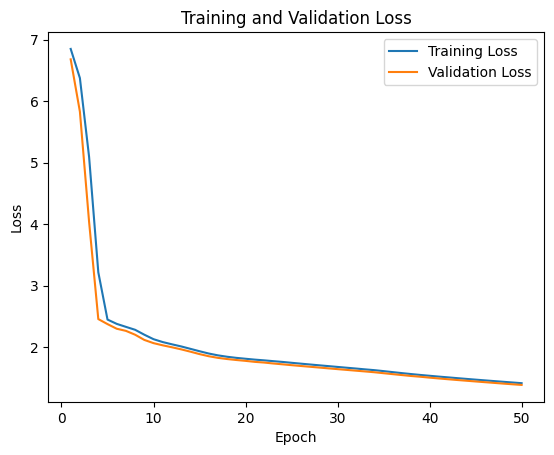

In [80]:
# Plot the training and validation loss curves
plt.plot(range(1, num_epochs+1), train_loss, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [81]:
import nltk
from nltk.translate.bleu_score import corpus_bleu

In [83]:
# Generate captions for test images using the trained model
predicted_sequences = model.predict([test_images, test_sequences_pad])
predicted_sequences = np.argmax(predicted_sequences, axis=2)

4/4 [==============================] - 3s 84ms/step


In [84]:
test_sequences_pad[2]

array([  4,   1,   9,  23,  30,  17,  14,   1, 129, 142,  19,  39,   1,
         8,  12,  11,  35,  31,  22,   6,  24,   5,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [85]:
predicted_sequences[2]

array([ 4,  0,  0,  2, 11,  8,  2,  1, 12, 34, 11, 12,  1,  2, 11, 11, 12,
        8,  8,  1, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [86]:
# Convert sequences to text
predicted_captions = []
for sequence in predicted_sequences:
    caption = []
    for idx in sequence:
        if idx == 0:
            continue
        word = tokenizer.sequences_to_texts([sequence])[0]
        if word == '':
            continue
        if word == '<end>':
            break
        caption.append(word)
    predicted_captions.append(' '.join(caption))

In [87]:
# predicted_captions = []
# for sequence in predicted_sequences:
#   caption = []
#   if sequence.all == 0:
#       continue
#   word = tokenizer.sequences_to_texts([[sequence]])[0]
#   if word == '':
#       continue
#   caption.append(word)
# predicted_captions = ' '.join(caption)


In [88]:
# Convert sequences to text
actual_captions = []
for sequence in test_sequences:
    caption = []
    for idx in sequence:
        if idx == 0:
            continue
        word = tokenizer.sequences_to_texts([sequence])[0]
        if word == '':
            continue
        if word == '<end>':
            break
        caption.append(word)
    actual_captions.append(' '.join(caption))

In [89]:
actual_captions[2]

'startseq no acute cardiopulmonary abnormality clear lungs no infiltrates suspicious pulmonary opacity no pleural effusion pneumothora cardiomediastinal silhouette within normal limits endseq startseq no acute cardiopulmonary abnormality clear lungs no infiltrates suspicious pulmonary opacity no pleural effusion pneumothora cardiomediastinal silhouette within normal limits endseq startseq no acute cardiopulmonary abnormality clear lungs no infiltrates suspicious pulmonary opacity no pleural effusion pneumothora cardiomediastinal silhouette within normal limits endseq startseq no acute cardiopulmonary abnormality clear lungs no infiltrates suspicious pulmonary opacity no pleural effusion pneumothora cardiomediastinal silhouette within normal limits endseq startseq no acute cardiopulmonary abnormality clear lungs no infiltrates suspicious pulmonary opacity no pleural effusion pneumothora cardiomediastinal silhouette within normal limits endseq startseq no acute cardiopulmonary abnormalit

In [90]:
# Compute the BLEU score
actual_captions = [[caption.split()] for caption in actual_captions]
predicted_captions = [caption.split() for caption in predicted_captions]
bleu_score = corpus_bleu(actual_captions, predicted_captions)
print('BLEU Score:', bleu_score)


BLEU Score: 0.010657507758214578
